#  Weather comparison of Korean cities

The following code shows how to fetch and analyze weather data from [KMA (Korea Meteorological Administration)](http://web.kma.go.kr/eng/) website.

Pohang


,count,mean,std,min,25%,50%,75%,max
humidity,24.0,69.791667,7.615654,53.0,64.000,72.00,75.000,82.0
temperature,24.0,30.958333,1.909226,28.1,29.375,30.70,32.725,34.9
wind_velocity,24.0,2.016667,0.860569,0.5,1.600,2.15,2.600,3.6


Seoul


,count,mean,std,min,25%,50%,75%,max
humidity,24.0,74.291667,14.122074,50.0,61.500,76.50,87.250,90.0
temperature,24.0,28.550000,2.189302,26.4,26.775,27.85,30.375,32.9
wind_velocity,24.0,2.200000,0.688413,0.7,1.800,2.20,2.650,3.3


Busan


,count,mean,std,min,25%,50%,75%,max
humidity,24.0,81.250000,7.594334,63.0,74.500,83.50,87.250,90.0
temperature,24.0,28.829167,1.832670,26.8,27.400,28.15,30.675,32.6
wind_velocity,24.0,4.000000,1.372399,0.6,3.175,4.05,4.975,6.0


Daegu


,count,mean,std,min,25%,50%,75%,max
humidity,24.0,68.583333,11.687662,49.0,59.5,74.50,78.000,81.0
temperature,24.0,30.120833,2.568704,27.2,28.1,29.10,32.075,34.7
wind_velocity,24.0,1.591667,0.832449,0.4,0.9,1.45,2.225,3.8


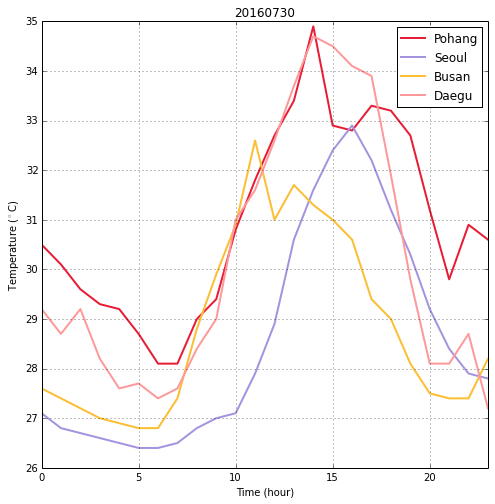

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import display
from multiprocessing import Pool, freeze_support
from datetime import date, timedelta
from bs4 import BeautifulSoup
from urllib2 import urlopen
import pandas as pd

def yesterday():
    '''
    Get the date of yesterday
    '''
    yesterday = date.today() - timedelta(1)
    return yesterday.strftime('%Y%m%d')

def get_weather_data(when, where):
    '''
    Get weather data by date and city code
    '''
    base_url = 'http://www.kma.go.kr/cgi-bin/aws/nph-aws_txt_min'
    query_str = '%s2300&0&MINDB_60M&%d&m' % (when, where)
    url = '%s?%s' % (base_url, query_str) # Create the target URL
    soup = BeautifulSoup(urlopen(url),'lxml') # Scraping the HTML

    temperature, wind_velocity, humidity = [], [], []
    # Extract weather data by parsing the BeautifulSoup object
    for row in soup.findAll('tr')[2:26]:
        col = row.findAll('td')
        temperature.insert(0, (float(col[7].text)))
        wind_velocity.insert(0, (float(col[10].text)))
        humidity.insert(0, (int(col[14].text)))

    # Create a pandas dataframe
    df = {'temperature':temperature, 'wind_velocity':wind_velocity, 'humidity':humidity}
    return pd.DataFrame(df)

if __name__ == '__main__':
    freeze_support() # For Windows compatibility

    pool = Pool()

    city_codes = [138, 108, 159, 143]
    city_names = ['Pohang','Seoul','Busan','Daegu']
    day = yesterday()

    # Execute parallel jobs in background
    results = [pool.apply_async(get_weather_data, (day, city)) for city in city_codes]

    plt.figure(figsize=(8,8))
    line_colors = ['#e71d36','#a593e0','#fcbe32','#fd999a']
    for k, r in enumerate(results):
        data = r.get()
        print city_names[k]
        display(data.describe().transpose())
        plt.plot(data.index.tolist(),data['temperature'],label=city_names[k],color=line_colors[k],linewidth=2)

    plt.legend(loc='upper right', numpoints=1)
    plt.xlabel('Time (hour)')
    plt.ylabel('Temperature ($^\circ$C)')
    plt.xlim((0,23))
    plt.grid(True)
    plt.title(day)
    plt.show()